In [7]:
import os
import pandas as pd
import config
import matplotlib.pyplot as plt
import numpy as np
import ast

In [6]:
root_dir = "/home/ubuntu/fma_metadata"
echonest_file = os.path.join(root_dir, "echonest.csv")
features_file = os.path.join(root_dir, "features.csv")
genres_file = os.path.join(root_dir, "genres.csv")
tracks_file = os.path.join(root_dir, "tracks.csv")

In [8]:
def getTracks(tracks):
    COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
               ('track', 'genres'), ('track', 'genres_all')]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
               ('album', 'date_created'), ('album', 'date_released'),
               ('artist', 'date_created'), ('artist', 'active_year_begin'),
               ('artist', 'active_year_end')]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
        'category', categories=SUBSETS, ordered=True)

    COLUMNS = [('track', 'genre_top'), ('track', 'license'),
               ('album', 'type'), ('album', 'information'),
               ('artist', 'bio')]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype('category')

    return tracks

In [10]:
tracks = getTracks(pd.read_csv(tracks_file, index_col=0, header=[0, 1]))
genres = pd.read_csv(genres_file, index_col=0)
features = pd.read_csv(features_file, index_col=0, header=[0,1,2])
echonest = pd.read_csv(echonest_file, index_col=0, header=[0,1,2])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  app.launch_new_instance()


In [11]:
print("Tracks: {}, Genres: {}, Features: {}, Echonest:{} "
      .format(
      tracks.shape,
      genres.shape,
      features.shape,
      echonest.shape))

Tracks: (106574, 52), Genres: (163, 4), Features: (106574, 518), Echonest:(13129, 249) 


In [12]:
print('{} tracks, {} artists, {} albums, {} genres'.format(
    len(tracks), len(tracks['artist', 'id'].unique()),
    len(tracks['album', 'id'].unique()),
    sum(genres['#tracks'] > 0)))

106574 tracks, 16341 artists, 14854 albums, 161 genres


In [13]:
mean_duration = tracks['track', 'duration'].mean()
print('track duration: {:.0f} days total, {:.0f} seconds average'.format(
    sum(tracks['track', 'duration']) / 3600 / 24,
    mean_duration))

track duration: 342 days total, 278 seconds average


In [14]:
d = tracks[tracks['set', 'subset'] <= 'medium']
d = d['track', 'genre_top'].value_counts()
print(d)

Rock                   7103
Electronic             6314
Experimental           2251
Hip-Hop                2201
Folk                   1519
Instrumental           1350
Pop                    1186
International          1018
Classical               619
Old-Time / Historic     510
Jazz                    384
Country                 178
Soul-RnB                154
Spoken                  118
Blues                    74
Easy Listening           21
Name: (track, genre_top), dtype: int64


In [21]:
print("\n\nFEATURES\n\n\n")
features.head(5).style.format('{:.2f}')



FEATURES





In [25]:
print("\n\nECHONEST FEATURES\n")
print('Echonest features available for {} tracks.'.format(len(echonest)))
pd.options.display.float_format = '{:,.2f}'.format
echonest.head(5)



ECHONEST FEATURES

Echonest features available for 13129 tracks.


echonest                                                \
         audio_features                                                 
           acousticness danceability energy instrumentalness liveness   
track_id                                                                
2                  0.42         0.68   0.63             0.01     0.18   
3                  0.37         0.53   0.82             0.00     0.11   
5                  0.04         0.75   0.70             0.00     0.37   
10                 0.95         0.66   0.92             0.97     0.12   
134                0.45         0.51   0.56             0.02     0.10   

                                                                    ...    \
                                       metadata                     ...     
         speechiness  tempo valence  album_date         album_name  ...     
track_id                                                            ...     
2               0.16 165.92    0.58         NaN                NaN  ...     
3               0.46 126.96    0.27         NaN                NaN  ...     
5               0.12 100.26    0.62         NaN                NaN  ...     
10              0.03 111.56    0.96  2008-03-11  Constant Hitmaker  ...     
134             0.53 114.29    0.89         NaN                NaN  ...     

                                                                               
         temporal_features                                                     
                       214   215  216  217  218  219   220   221   222    223  
track_id                                                                       
2                    -1.99  6.81 0.23 0.19 0.03 0.06  3.68  3.61 13.32 262.93  
3                    -1.58  8.89 0.26 0.22 0.08 0.06  6.08  6.02 16.67 325.58  
5                    -2.29 11.53 0.26 0.24 0.06 0.06  5.93  5.87 16.01 356.76  
10                   -3.66 21.51 0.28 0.27 0.13 0.08  8.41  8.33 21.32 483.40  
134                  -1.45  2.36 0.23 0.20 0.15 0.06 11.27 11.20 26.45 751.15  

[5 rows x 249 columns]

Plot to show the distribution of albums in terms of their release year

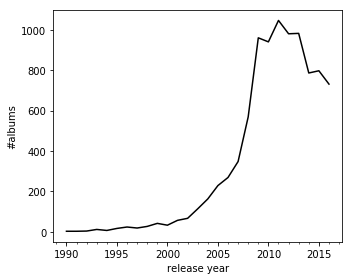

In [27]:
plt.figure(figsize=(5, 4))
d = tracks['album'].drop_duplicates('id')
d = pd.Series(1, index=d['date_released'])
d = d.resample('A').sum().fillna(0)
b = d.index >= pd.to_datetime(1990, format='%Y')
b &= d.index <= pd.to_datetime(2017, format='%Y')
d[b].plot(color='k')
plt.xlabel('release year')
plt.ylabel('#albums')
plt.tight_layout()
plt.show()